In [1]:
# Import required libraries
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
#plt.rcParams['pdf.fonttype'] = 42
import pandas as pd
from IPython.core.display import HTML
import numpy as np
%matplotlib inline
import glob
import readData
reload(readData) #avoid kernel restart if changed
import re
import databaseQuery

In [47]:
## Read in the data as a pandas dataframe
# Files should be .csv format in \Data\ subdirectory
# Files should be simply named SAGE_SOUTH or RIV_NORTH, without numerals
allFiles = glob.glob("Data\*.csv") #get all files with csv extension in this subfolder
print allFiles


#Return pandas dataframe with all the data, datetime index
#toggle saveCSV True/False to save a csv of the compiled data

voltage, radius = readData.readCSV(allFiles, saveCSV = False) 


['Data\\RIV_NORTH.csv', 'Data\\RIV_SOUTH.csv', 'Data\\SAGE_NORTH.csv', 'Data\\SAGE_SOUTH.csv']


In [3]:
radius.head()

,60021,60023,60024,60025,60027,60002,60003,60001,60004,60006,60007,60018,60019,60017,60016,60015,60012,60013
2015-06-25 12:30:00,2.66044,13589.60000,2.66044,4288.80000,2.66044,NaN,NaN,NaN,NaN,NaN,NaN,3.97892,3.97892,3.97892,3.97892,3.97892,-2960.56,-3659.52
2015-06-25 13:00:00,2.66048,13585.60000,2.66048,4279.60000,2.66048,2.63844,2.63844,2.63844,2.63844,3.94492,3.50660,3.97892,3.97892,3.97892,3.97892,3.97892,-3608.44,-5562.80
2015-06-25 13:30:00,2.66044,2.65824,2.66044,2.66020,2.66044,2.63844,2.63844,2.63844,2.63844,3.72580,3.50664,3.97884,3.97884,3.97884,3.97884,3.97884,-3876.96,-5849.60
2015-06-25 14:00:00,2.66040,2.65820,2.66040,2.66016,2.66040,2.63844,2.63844,2.63844,2.63844,3.94492,3.72576,3.75784,3.97888,3.97888,3.97888,3.97888,-4281.60,-6322.00
2015-06-25 14:00:00,2.66040,2.65820,2.66040,2.66016,2.66040,2.63844,2.63844,2.63844,2.63844,17268.00000,9130.00000,3.75784,3.97888,3.97888,3.97888,3.97888,-4281.60,-6322.00


In [4]:
## Read in the metadata as a pandas dataframe
metadata = pd.read_csv('PISTON_DENDROMETER_METADATA.csv',sep=',', dtype=str)

#Create dictionaries between sensor ID and metadata info
Site = dict(zip(metadata['Micron Displacement DSID'], metadata['Site'] )) 
Slope = dict(zip(metadata['Micron Displacement DSID'], metadata['Slope'] )) 
Species = dict(zip(metadata['Micron Displacement DSID'], metadata['Species'] )) 
Tree = dict(zip(metadata['Micron Displacement DSID'], metadata['Tree #'] )) 


In [5]:
metadata.head()

,Site,Tree #,Species,Slope,Side of Tree,Sensor ID,SE Channel Data Logger,EX Channel Data Logger,Data Logger Turn On Date,Data Logger Turn-on Time,Height Above Ground (m) (+/- 1 m),Notes,Include,Raw Voltage DSID,Micron Displacement DSID,Unnamed: 15,Unnamed: 16,Notes.1
0,Sagehorn,205,QUGA,S,NE,7,2,1,8/6/2015,18:49,3,NaN,no,50000,60000,NaN,NaN,We scraped away what we interpreted to be dead...
1,Sagehorn,205,QUGA,S,SW,27,4,2,8/6/2015,18:49,3,Threaded rods not srewed in all the way (yet)....,yes,50001,60001,NaN,NaN,We threaded rods approximately 15 cm in total ...
2,Sagehorn,206,QUGA,S,SW,6,1,1,8/6/2015,18:49,3,Threaded rods not srewed in all the way (yet)....,yes,50002,60002,NaN,NaN,NaN
3,Sagehorn,206,QUGA,S,E,23,3,2,8/6/2015,18:49,3,Threaded rods not srewed in all the way (yet)....,yes,50003,60003,NaN,NaN,NaN
4,Sagehorn,207,QUGA,S,E,43,6,3,8/6/2015,18:49,3,NaN,yes,50004,60004,NaN,NaN,NaN


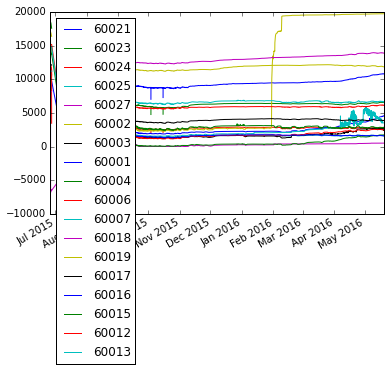

In [48]:
radius.plot()

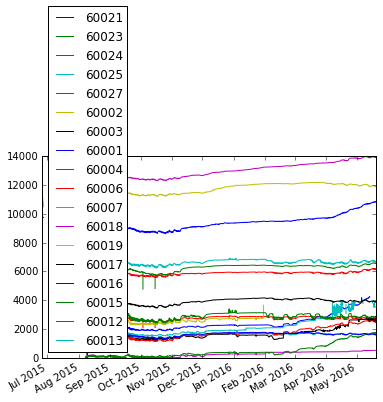

In [49]:
## Remove outliers
radiusMedian = radius.median()
radiusTrimmed = radius[(radius < (radiusMedian + 2000)) &
                (radius > (radiusMedian - 2000)) ]
radiusTrimmed.plot()

In [57]:
#%% SPECIFY TIME RANGE OF SERIES
startDateTime = pd.to_datetime('2016-05-01 05:00:00')
stopDateTime = pd.to_datetime('2016-05-08 05:00:00')
radiusTR = radiusTrimmed[(pd.to_datetime(radius.index) > startDateTime) & 
                (pd.to_datetime(radius.index) < stopDateTime)]


In [58]:
## Import from mySQL database 
#Convert datetime stamps to strings for the sql query
dateStart = str(startDateTime.year) + '-' + str(startDateTime.month) + '-' + str(startDateTime.day)
dateStop =  str(stopDateTime.year) + '-' + str(stopDateTime.month) + '-' + str(stopDateTime.day)

#here we make use of external .py file with odmquery function (thanks Collin!) to get data from the database
#1672 = cumulative WY precip, in mm
#1785 = Rainfall mm TB4 WSAM RWS_Rain_TB4_Tot2015-03-26 (ongoing)Rainfall mmAngelo Meadow WSwsam0 to 700TB4mm-L Rain Gage
#2958 = Barometric Pressure, WSSR, mBar
#2959 = Rainfall, WSSR, mm
#3048 = Rainfall Cumulative mm Sagehorn
# atmP = databaseQuery.odmquery(dateStart, dateStop, '2958', True)
# atmP.plot()
#rain = databaseQuery.odmquery(dateStart, dateStop, '2957', True)



In [59]:

#center to zero

radiusMin = radiusTR.apply(np.min)

radiusZeroed =  radiusTR-radiusMin



(0, 200)

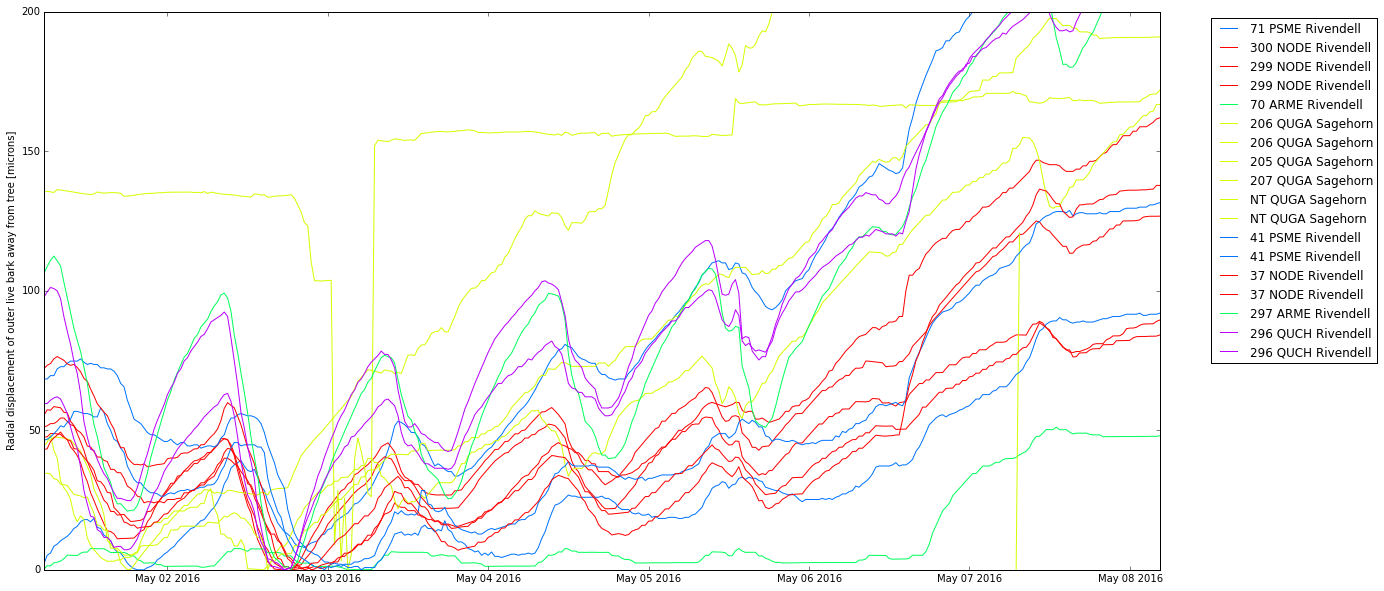

In [61]:
# fig, ax = plt.subplots(2, sharex=True, figsize=(17, 22))

fig = plt.figure(figsize=(20,10))
# Get unique names of species
uniq = list(set(metadata['Species']))

# Set the color map to match the number of species
# z = range(1,len(uniq))
hot = plt.get_cmap('hot')
cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('hsv') )


for column in radiusZeroed:
#         plt.figure()
    ax = plt.plot(radiusZeroed.index, radiusZeroed[column], 
             color=scalarMap.to_rgba(uniq.index(Species[column])), 
             label = (Tree[column] + ' ' + Species[column] + ' ' + Site[column]))
    plt.legend(bbox_to_anchor=(1.2, 1))
plt.ylabel('Radial displacement of outer live bark away from tree [microns]')
plt.ylim([0,200])
#plt.savefig('pistonDendroDiurnal.pdf', format='pdf', bbox_inches='tight')

$$a + b / 3$$